# Sampling, Bias, and Community Structure in Real Networks

## Part A — Sampling and Bias in Network Analysis (15 pts)

Goal: Investigate how different sampling methods can change the observed structure of a social network.

In [45]:
import networkx as nx
import random
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
G_fb = nx.read_edgelist("facebook_combined.txt", nodetype=int)

### A1 – Create Two Samples (6 pts)

In [72]:
# 1. Random Sample – Randomly select 250 nodes.
nodes = random.sample(sorted(G_fb.nodes()), 250)
G_random = G_fb.subgraph(nodes).copy()

# 2. Ego-Centered Sample – Pick a node with degree > 50 and build its 1.5-degree ego network.
center = max(G_fb, key=lambda n: G_fb.degree(n))
G_ego = nx.ego_graph(G_fb, center, radius=1)
print(
    tabulate(
        [
            ["Random", G_random.number_of_nodes(), G_random.number_of_edges()],
            ["Ego", G_ego.number_of_nodes(), G_ego.number_of_edges()],
        ],
        headers=["Sample", "# Nodes", "# Edges"]
    )
)

Sample      # Nodes    # Edges
--------  ---------  ---------
Random          250        376
Ego            1046      27795


## A2 – Compute and Visualize Metrics (6 pts)

For each sample (`G_random`, `G_ego`):

- Compute Average Clustering Coefficient (C)
- Compute Average Shortest Path Length (L) (on largest component if needed)
- Find Maximum Degree (Max k)

### 1. Table of Metrics

In [73]:
print(
    tabulate(
        [
            [
                "Random",
                round(nx.average_clustering(G_random), 2),
                round(
                    nx.average_shortest_path_length(
                        G_random.subgraph(
                            max(nx.connected_components(G_random), key=len)
                        )
                    ),
                    2,
                ),
                max(G_random.degree, key=lambda x: x[1])[1],
            ],
            [
                "Ego",
                round(nx.average_clustering(G_ego), 2),
                round(
                    nx.average_shortest_path_length(
                        G_ego.subgraph(
                            max(nx.connected_components(G_ego), key=len)
                        )
                    ),
                    2,
                ),
                max(G_ego.degree, key=lambda x: x[1])[1],
            ],
        ],
        headers=["Sample", "Avg Clustering (C)", "Avg Path (L)", "Max Degree"]
    )
)

Sample      Avg Clustering (C)    Avg Path (L)    Max Degree
--------  --------------------  --------------  ------------
Random                    0.35            1.93            14
Ego                       0.58            1.95          1045


### 2. Two degree distribution plots (log–log axes)

Each plot must include a title, axis labels (“Degree (k)” and “Count of Nodes”)

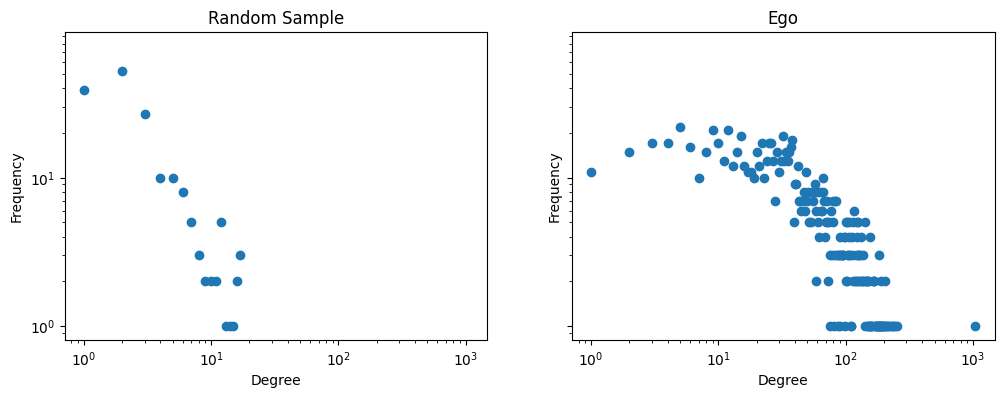

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

axes[0].set_title("Random Sample")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_random)
degrees = range(len(degree_freq))
axes[0].loglog(degrees, degree_freq, "o")

axes[1].set_title("Ego")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Frequency")
degree_freq = nx.degree_histogram(G_ego)
degrees = range(len(degree_freq))
axes[1].loglog(degrees, degree_freq, "o")
plt.show()